In [78]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [79]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ashish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [80]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [81]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier

In [82]:
theme_classifier = load_model(device)

/home/ashish/development/series-analysis-system/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [83]:
theme_list = ["friendship", "hope", "scarifice", "battle", "self development", "betrayal", "love", "dialogue"]

In [84]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'scarifice',
  'self development',
  'hope',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.912125289440155,
  0.49253398180007935,
  0.47500237822532654,
  0.0878179669380188,
  0.020132793113589287,
  0.012040523812174797,
  0.004292386583983898,
  0.0028172149322927]}

# Load Dataset

In [85]:
files = glob('../data/Subtitles/*.ass')

In [86]:
files[:5]

['../data/Subtitles/Naruto Season 7 - 163.ass',
 '../data/Subtitles/Naruto Season 2 - 48.ass',
 '../data/Subtitles/Naruto Season 3 - 60.ass',
 '../data/Subtitles/Naruto Season 5 - 107.ass',
 '../data/Subtitles/Naruto Season 3 - 66.ass']

In [87]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [88]:
lines[:2]

['I want to try and gather\\Nthe unrestrained winds\n',
 'I’ll run toward the horizon,\\Nalongside the wave crests\n']

In [89]:
lines = [line.replace('\\N', '') for line in lines]

In [90]:
lines[:2]

['I want to try and gatherthe unrestrained winds\n',
 'I’ll run toward the horizon,alongside the wave crests\n']

In [91]:
" ".join(lines[:10])

'I want to try and gatherthe unrestrained winds\n I’ll run toward the horizon,alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to goon that road.\n I’ll continue towards the future I’ve planned\n Time rushes usThe heartbeat speeds up\n When I woke in the middle of a dreamI kept searching for that same light\n Under the shining star-lit sky withcountless constellations and shadows\n There was something beyond that…What were you gazing at?\n What were you gazing at?\n'

In [92]:
int(files[0].split('-')[-1].split('.')[0].strip())

163

In [93]:
def load_subtitles_dataset(dataset_path):
    sibtitles_path = glob(f'{dataset_path}/*.ass')

    scripts = []
    episode_num = []

    for path in sibtitles_path:

        # Read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]

        lines = [line.replace('\\N', '') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)
    
    df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})
    return df
                          

In [94]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [95]:
df.head()

,episode,script
0,163,I want to try and gatherthe unrestrained winds...
1,48,"Press down hard on the gas\n That’s right, the..."
2,60,"Yeah, turn your sadness into kindness,your uni..."
3,107,Connecting old wordsthat have been used up\n I...
4,66,"Yeah, turn your sadness into kindness,your uni..."


Run Model

In [96]:
script = df.iloc[0]['script']

In [97]:
script

"I want to try and gatherthe unrestrained winds\n I’ll run toward the horizon,alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to goon that road.\n I’ll continue towards the future I’ve planned\n Time rushes usThe heartbeat speeds up\n When I woke in the middle of a dreamI kept searching for that same light\n Under the shining star-lit sky withcountless constellations and shadows\n There was something beyond that…What were you gazing at?\n What were you gazing at?\n Is this really Moso’s house?\n Here he’s a superintendant officer,\n so I thought it’d be a more luxuriousbuilding with gold folding screens.\n Your voices are too loud.\n Lord Moso is a magnificent personwith no self-interests.\n So he lives frugally.\n But you know, he’s an old man\n who’s the second most important guyin the land next to the feudal lord, right?\n He smacks of being really poor.\n Naruto!\n Well well, how shameful of meto present such a poor residence.\n Lord Moso.\n What?!\n

In [98]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['I want to try and gatherthe unrestrained winds\n I’ll run toward the horizon,alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to goon that road.',
 'I’ll continue towards the future I’ve planned\n Time rushes usThe heartbeat speeds up\n When I woke in the middle of a dreamI kept searching for that same light\n Under the shining star-lit sky withcountless constellations and shadows\n There was something beyond that…What were you gazing at?',
 'What were you gazing at?']

In [99]:
# Batch sentences
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

    break

In [100]:
script_batches[:2]

['I want to try and gatherthe unrestrained winds\n I’ll run toward the horizon,alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to goon that road. I’ll continue towards the future I’ve planned\n Time rushes usThe heartbeat speeds up\n When I woke in the middle of a dreamI kept searching for that same light\n Under the shining star-lit sky withcountless constellations and shadows\n There was something beyond that…What were you gazing at? What were you gazing at? Is this really Moso’s house? Here he’s a superintendant officer,\n so I thought it’d be a more luxuriousbuilding with gold folding screens. Your voices are too loud. Lord Moso is a magnificent personwith no self-interests. So he lives frugally. But you know, he’s an old man\n who’s the second most important guyin the land next to the feudal lord, right? He smacks of being really poor. Naruto! Well well, how shameful of meto present such a poor residence. Lord Moso. What?! This old man like fromsome

In [101]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [102]:
theme_output

[{'sequence': 'I want to try and gatherthe unrestrained winds\n I’ll run toward the horizon,alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to goon that road. I’ll continue towards the future I’ve planned\n Time rushes usThe heartbeat speeds up\n When I woke in the middle of a dreamI kept searching for that same light\n Under the shining star-lit sky withcountless constellations and shadows\n There was something beyond that…What were you gazing at? What were you gazing at? Is this really Moso’s house? Here he’s a superintendant officer,\n so I thought it’d be a more luxuriousbuilding with gold folding screens. Your voices are too loud. Lord Moso is a magnificent personwith no self-interests. So he lives frugally. But you know, he’s an old man\n who’s the second most important guyin the land next to the feudal lord, right? He smacks of being really poor. Naruto! Well well, how shameful of meto present such a poor residence. Lord Moso. What?! This old man 

In [103]:
# wrangle output
# battle: [0.23424, 0.434343]
themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [104]:
themes = {key: float(np.mean(np.array(value))) for key,value in themes.items()}

In [105]:
themes

{'dialogue': 0.9760727286338806,
 'betrayal': 0.905784010887146,
 'self development': 0.7529134154319763,
 'scarifice': 0.7338353991508484,
 'battle': 0.31400066614151,
 'love': 0.1942243129014969,
 'friendship': 0.09916046261787415,
 'hope': 0.06654246896505356}

In [106]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    #  Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output
    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
    
    themes = {key: float(np.mean(np.array(value))) for key,value in themes.items()}

    return themes

In [107]:
df = df.head(2)

In [108]:
df

,episode,script
0,163,I want to try and gatherthe unrestrained winds...
1,48,"Press down hard on the gas\n That’s right, the..."


In [109]:
output_themes = df['script'].apply(get_themes_inference)

In [110]:
output_themes

0    {'dialogue': 0.93843674659729, 'betrayal': 0.5...
1    {'battle': 0.9050994515419006, 'dialogue': 0.9...
Name: script, dtype: object

In [111]:
theme_df = pd.DataFrame(output_themes.tolist())

In [112]:
theme_df

,dialogue,betrayal,self development,scarifice,battle,love,friendship,hope
0,0.938437,0.536547,0.683639,0.662463,0.404202,0.131441,0.207619,0.518703
1,0.958955,0.416744,0.918433,0.757559,0.905099,0.392423,0.543345,0.547491


In [113]:
df

,episode,script
0,163,I want to try and gatherthe unrestrained winds...
1,48,"Press down hard on the gas\n That’s right, the..."


In [114]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,self development,scarifice,battle,love,friendship,hope
0,163,I want to try and gatherthe unrestrained winds...,0.938437,0.536547,0.683639,0.662463,0.404202,0.131441,0.207619,0.518703
1,48,"Press down hard on the gas\n That’s right, the...",0.958955,0.416744,0.918433,0.757559,0.905099,0.392423,0.543345,0.547491


# Visualize Output

In [ ]:
df = df.drop('dialogue', axis=1)

,episode,script,betrayal,self development,scarifice,battle,love,friendship,hope
0,163,I want to try and gatherthe unrestrained winds...,0.536547,0.683639,0.662463,0.404202,0.131441,0.207619,0.518703
1,48,"Press down hard on the gas\n That’s right, the...",0.416744,0.918433,0.757559,0.905099,0.392423,0.543345,0.547491


In [119]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,0.953290
1,self development,1.602072
2,scarifice,1.420022
3,battle,1.309301
4,love,0.523863
5,friendship,0.750963
6,hope,1.066194


In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

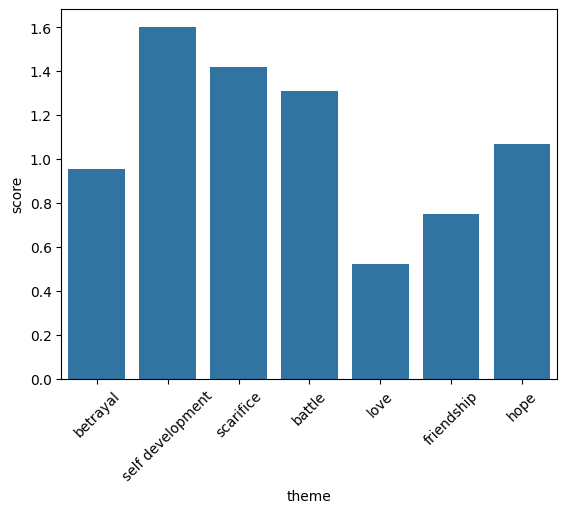

In [123]:
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()